In [1]:
!git clone https://github.com/IMvision12/SegFormer-tf

Cloning into 'SegFormer-tf'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 146 (delta 10), reused 9 (delta 9), pack-reused 133
Receiving objects: 100% (146/146), 271.94 KiB | 8.77 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [2]:
cd SegFormer-tf

/kaggle/working/SegFormer-tf


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import glob

#SegFormer
from models import SegFormer_B2

In [4]:
img = glob.glob('/kaggle/input/cityscapes/Cityspaces/images/train/*/*.png') # tf.io.glob.glob
label = glob.glob('/kaggle/input/cityscapes/Cityspaces/gtFine/train/*/*_gtFine_labelIds.png')
img_names = [path.split('/train/')[1].split('_leftImg8bit.png')[0] for path in img]
label = ['/kaggle/input/cityscapes/Cityspaces/gtFine/train/' + name + '_gtFine_labelIds.png' for name in img_names]

val_img = glob.glob('/kaggle/input/cityscapes/Cityspaces/images/val/*/*.png') # tf.io.glob.glob
val_label = glob.glob('/kaggle/input/cityscapes/Cityspaces/gtFine/val/*/*_gtFine_labelIds.png')
img_names = [path.split('/val/')[1].split('_leftImg8bit.png')[0] for path in val_img]
val_label = ['/kaggle/input/cityscapes/Cityspaces/gtFine/val/' + name + '_gtFine_labelIds.png' for name in img_names]

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((img, label))
val_ds = tf.data.Dataset.from_tensor_slices((val_img, val_label))

In [6]:
def read_image(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256,256])
    return img
    
def read_mask(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [256,256])
    return img

def rand_crop(img, mask):
    concat_img = tf.concat([img, mask], axis=-1)
    concat_img = tf.image.resize(concat_img, [280, 560], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [256, 256, 4])
    return crop_img[:, :, :3], crop_img[:, :, 3:]

def norm(image, mask):
    image = tf.cast(image, tf.float32)/127.5-1
    mask = tf.cast(mask, tf.int32)
    return image, mask

In [7]:
def load_img_train(img, mask):
    image = read_image(img)
    mask = read_mask(mask)
    image, mask = rand_crop(image, mask)
    return norm(image, mask)

def load_img_val(img, mask):
    image = read_image(img)
    mask = read_mask(mask)
    return norm(image, mask)

In [8]:
train_ds = train_ds.map(load_img_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(8)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(load_img_val, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(8)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
def plot_images(img_batch, mask_batch):
    batch_size = img_batch.shape[0]
    num_cols = int(math.sqrt(batch_size))
    num_rows = math.ceil(batch_size / num_cols)
    
    fig, axes = plt.subplots(num_rows, 2*num_cols, figsize=(15, 15), gridspec_kw={'hspace': 0.005})
    for i in range(batch_size):
        row = i // num_cols
        col = i % num_cols
        
        axes[row, 2*col].imshow((img_batch[i]+1) / 2)
        axes[row, 2*col].axis('off')
        axes[row, 2*col+1].imshow(mask_batch[i])
        axes[row, 2*col+1].axis('off')
    
    plt.show()

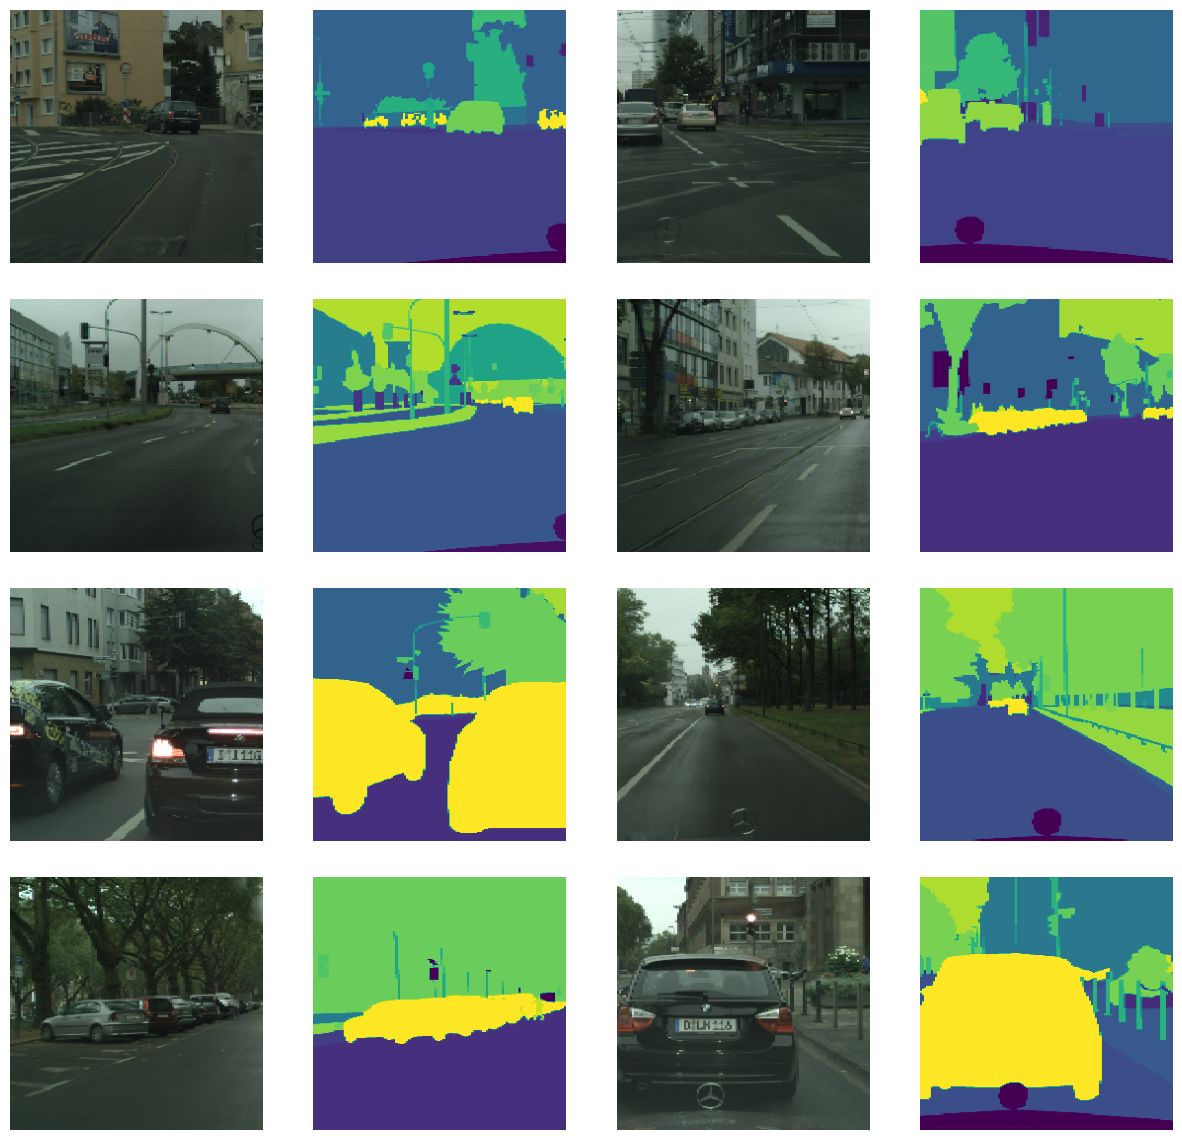

In [10]:
for img_batch, mask_batch in train_ds.take(1):
    plot_images(img_batch, mask_batch)

# Model

In [11]:
model = SegFormer_B2(input_shape = (256,256,3), num_classes = 34)

In [12]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
steps_per_epoch = 2975 // 8
validation_steps = 500 // 8

In [14]:
history = model.fit(train_ds, steps_per_epoch=steps_per_epoch, validation_data=val_ds, validation_steps=validation_steps, epochs=100)

Epoch 1/100


2023-05-06 20:20:29.250673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/seg_former_head/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


371/371 [==============================] - 375s 779ms/step - loss: 1.3169 - accuracy: 0.5954 - val_loss: 1.6588 - val_accuracy: 0.5100
Epoch 2/100
371/371 [==============================] - 267s 721ms/step - loss: 1.1645 - accuracy: 0.6460 - val_loss: 1.8476 - val_accuracy: 0.5199
Epoch 3/100
371/371 [==============================] - 257s 694ms/step - loss: 0.9897 - accuracy: 0.7228 - val_loss: 1.9256 - val_accuracy: 0.5237
Epoch 4/100
371/371 [==============================] - 256s 692ms/step - loss: 0.9001 - accuracy: 0.7493 - val_loss: 1.2472 - val_accuracy: 0.6851
Epoch 5/100
371/371 [==============================] - 256s 691ms/step - loss: 0.8360 - accuracy: 0.7686 - val_loss: 1.1830 - val_accuracy: 0.7041
Epoch 6/100
371/371 [==============================] - 285s 770ms/step - loss: 0.7953 - accuracy: 0.7800 - val_loss: 1.1196 - val_accuracy: 0.7017
Epoch 7/100
371/371 [==============================] - 270s 729ms/step - loss: 0.7457 - accuracy: 0.7952 - val_loss: 1.0554 - val_

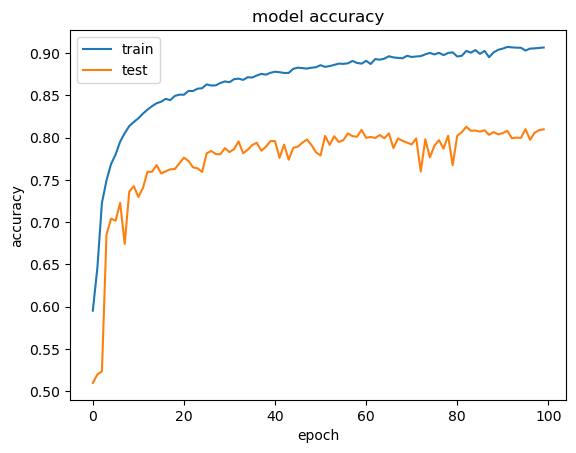

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

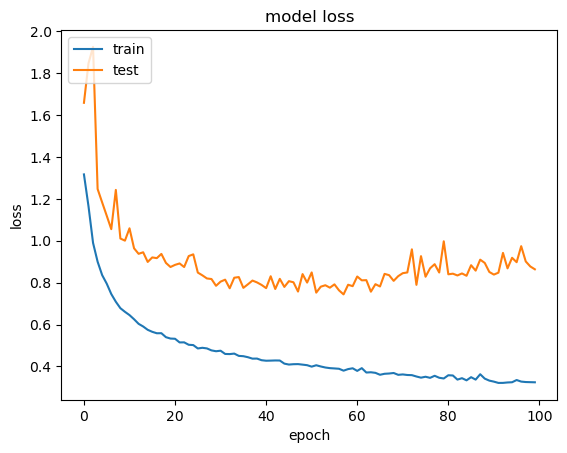

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 6s 6s/step


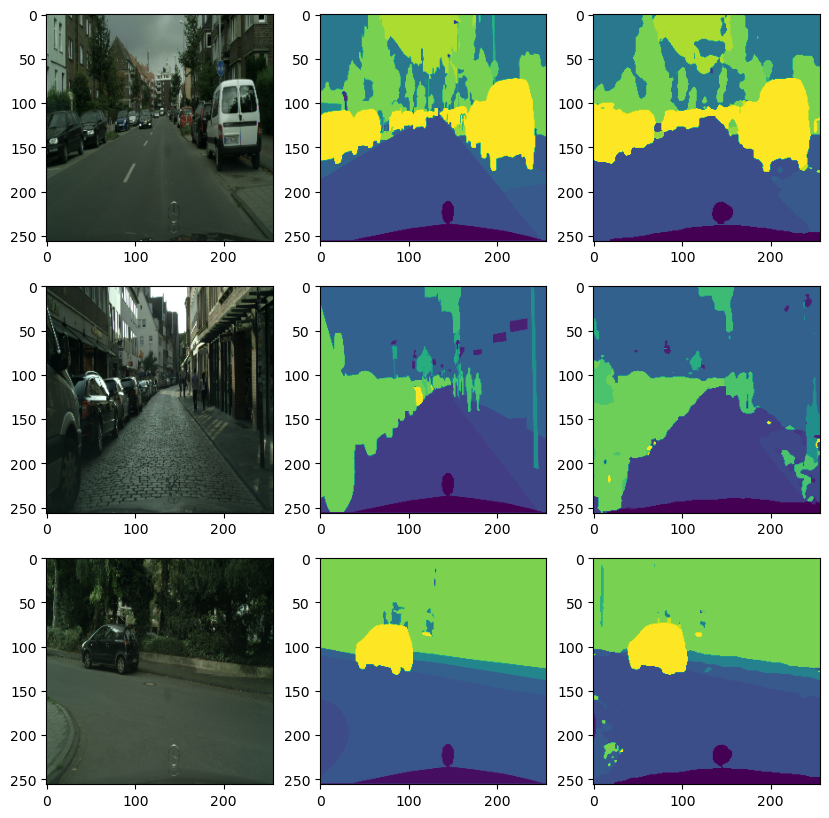

In [17]:
num = 3

for img, label in val_ds.take(1):
    pred_label = model.predict(img)
    pred_label = tf.argmax(pred_label, axis=-1)
    pred_label = pred_label[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(label[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_label[i]))